In [31]:
import sys

from collections import Counter

import torch
from torch import nn

from itertools import chain

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random
import os

import pandas as pd

from celeb_backbone import *
from basic_task import *

In [34]:
root = "celebA_embeddings/exp_age_final"

In [36]:
# class CelebAEmbeddingsDataset(Dataset):
#     def __init__(self, root="celebA_embeddings/", series_length=5, set="train"):
#         self.root = root
#         self.series_length = series_length 
#         self.stim_dir = Path(root, f"seq{series_length}", set)
#         self.contents = sorted(Path(self.stim_dir).iterdir(), key=lambda x: x.name.lower())

#         print(self.stim_dir)
        
#     def __len__(self):
#         files = list(self.stim_dir.glob('*.pt'))
#         return len(files)

#     def __getitem__(self, idx):

#         item_path = self.contents[idx]
#         item = torch.load(item_path, weights_only=False)

#         sequence = item["sequence"]
#         sequence = sequence.squeeze(2) 
        
#         label = item["label"]      
#         label = torch.tensor(label, dtype=torch.long)

#         return (sequence, label)


# def data_prepper_preseparated(series_length, batch_size, seed_value, root="celebA_embeddings/exp_age",):
  

#     train_dataset = CelebAEmbeddingsDataset(root=root, series_length=series_length, set="train")
#     val_dataset = CelebAEmbeddingsDataset(root=root, series_length=series_length, set="val")
#     test_dataset = CelebAEmbeddingsDataset(root=root, series_length=series_length, set="test")

#     train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8, pin_memory=True)
#     val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8, pin_memory=True)
#     test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=8, pin_memory=True)

#     data_checks(train_dataset, val_dataset, test_dataset)
    
#     return train_dataloader, val_dataloader, test_dataloader


# def data_checks(train_dataset, val_dataset, test_dataset):

#     print("train:")
#     train_labels = [np.where(train_dataset[i][1])[0][0] for i in range(len(train_dataset))]
#     train_counts = Counter(train_labels)
#     print(train_counts)

#     print("\nval")
#     val_labels = [np.where(val_dataset[i][1])[0][0] for i in range(len(val_dataset))]
#     val_counts = Counter(val_labels)
#     print(val_counts)

#     print("\ntest")
#     test_labels = [np.where(test_dataset[i][1])[0][0] for i in range(len(test_dataset))]
#     test_counts = Counter(test_labels)
#     print(test_counts)

class CelebAEmbeddingsDataset(Dataset):
    def __init__(self, root="celebA_embeddings/", series_length=5, set="train"):
        self.root = root
        self.series_length = series_length 
        self.stim_dir = Path(root, f"seq{series_length}", set, set)
        self.contents = sorted(Path(self.stim_dir).iterdir(), key=lambda x: x.name.lower())

        print(self.stim_dir)
        
    def __len__(self):
        files = list(self.stim_dir.glob('*.pt'))
        return len(files)

    def __getitem__(self, idx):

        item_path = self.contents[idx]
        item = torch.load(item_path, weights_only=False)

        sequence = item["sequence"]
        sequence = sequence.squeeze(2) 
        
        label = item["label"]      
        label = torch.tensor(label, dtype=torch.long)

        return (sequence, label)


def data_prepper_preseparated(series_length, batch_size, seed_value, root="celebA_embeddings/exp_age",):
  

    train_dataset = CelebAEmbeddingsDataset(root=root, series_length=series_length, set="train")
    test_dataset = CelebAEmbeddingsDataset(root=root, series_length=series_length, set="test")

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=8, pin_memory=True)

    data_checks(train_dataset, test_dataset)
    
    return train_dataloader, test_dataloader


def data_checks(train_dataset, test_dataset):

    print("train:")
    train_labels = [np.where(train_dataset[i][1])[0][0] for i in range(len(train_dataset))]
    train_counts = Counter(train_labels)
    print(train_counts)

    print("\ntest")
    test_labels = [np.where(test_dataset[i][1])[0][0] for i in range(len(test_dataset))]
    test_counts = Counter(test_labels)
    print(test_counts)



In [37]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=5):
    batches_list = []
    loss_list = []

    test_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        for i, (sequences, labels) in enumerate(train_dataloader):
        
            sequences = sequences.to('cuda')
            labels = labels.to('cuda')
            sequences = sequences.squeeze(2) 
            preds = model(sequences)
            
            loss = criterion(preds.squeeze(), labels.float().squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds_ = torch.softmax(preds, dim=2)
            correct = (preds_.argmax(dim=2).T == labels.argmax(dim=1)).float().sum()
            
            batches_list.append(i)
            loss_list.append(loss.item())

            if i % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}, Accuracy: {correct.item()}/{labels.size(0)} ({100 * correct.item() / (labels.size(0)):.2f}%)')
        

        # test_loss = test_across_epochs(model, test_dataloader, )
        # test_loss_list.append(test_loss)

    return batches_list, loss_list, test_loss_list


def test_across_epochs(model, val_dataloader, ):
    
    loss_list = []

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in val_dataloader:
            
            sequences = sequences.to('cuda')
            labels = labels.to('cuda')

            sequences = sequences.squeeze(2) 
            preds = model(sequences)
            
            loss = criterion(preds.squeeze(), labels.float().squeeze())
            loss_list.append(loss.item())
            preds_ = torch.softmax(preds, dim=2)
            temp = (preds_.argmax(dim=2).T == labels.argmax(dim=1)).float().sum()
            correct += temp.item()
            total += labels.size(0)

    return loss_list

def test(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in test_dataloader:
            
            sequences = sequences.to('cuda')
            labels = labels.to('cuda')

            sequences = sequences.squeeze(2) 
            preds = model(sequences)

            preds_ = torch.softmax(preds, dim=2)
            temp = (preds_.argmax(dim=2).T == labels.argmax(dim=1)).float().sum()
            correct += temp.item()
            total += labels.size(0)

    print(f'Test Accuracy: {100 * correct / total}%')


In [38]:
### seq length 5


series_length = 5
batch_size = 128
seed_value = 100

train_dataloader, test_dataloader = data_prepper_preseparated(series_length, batch_size, seed_value, root,)


model = Vanilla_RNN(input_size=4096, hidden_size=1024, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

model1024 = train(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs)

test(model, test_dataloader)

celebA_embeddings/exp_age_final/seq5/train/train
celebA_embeddings/exp_age_final/seq5/test/test
train:
Counter({4: 7680, 3: 5760, 2: 3840, 1: 1920})

test
Counter({4: 7680, 3: 5760, 2: 3840, 1: 1920})
Epoch [1/20], Step [1/150], Loss: 1.6069, Accuracy: 19.0/128 (14.84%)
Epoch [1/20], Step [11/150], Loss: 1.2972, Accuracy: 52.0/128 (40.62%)
Epoch [1/20], Step [21/150], Loss: 1.2693, Accuracy: 53.0/128 (41.41%)
Epoch [1/20], Step [31/150], Loss: 1.2515, Accuracy: 51.0/128 (39.84%)
Epoch [1/20], Step [41/150], Loss: 1.3342, Accuracy: 48.0/128 (37.50%)
Epoch [1/20], Step [51/150], Loss: 1.2981, Accuracy: 53.0/128 (41.41%)
Epoch [1/20], Step [61/150], Loss: 1.2194, Accuracy: 48.0/128 (37.50%)
Epoch [1/20], Step [71/150], Loss: 1.1541, Accuracy: 68.0/128 (53.12%)
Epoch [1/20], Step [81/150], Loss: 0.7873, Accuracy: 83.0/128 (64.84%)
Epoch [1/20], Step [91/150], Loss: 0.3869, Accuracy: 107.0/128 (83.59%)
Epoch [1/20], Step [101/150], Loss: 0.2286, Accuracy: 120.0/128 (93.75%)
Epoch [1/20], St

In [24]:
### seq length 5


series_length = 5
batch_size = 128
seed_value = 100

train_dataloader, test_dataloader = data_prepper_preseparated(series_length, batch_size, seed_value, root,)


model = Vanilla_RNN(input_size=4096, hidden_size=512, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

model512 = train(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs)

test(model, test_dataloader)

celebA_embeddings/exp_basic/seq5/train/train
celebA_embeddings/exp_basic/seq5/test/test
train:


Counter({4: 480, 3: 352, 2: 232, 1: 120})

test
Counter({4: 480, 3: 352, 2: 232, 1: 120})
Epoch [1/20], Step [1/9], Loss: 1.6170, Accuracy: 0.0/128 (0.00%)
Epoch [2/20], Step [1/9], Loss: 1.2842, Accuracy: 52.0/128 (40.62%)
Epoch [3/20], Step [1/9], Loss: 1.2944, Accuracy: 49.0/128 (38.28%)
Epoch [4/20], Step [1/9], Loss: 1.3296, Accuracy: 49.0/128 (38.28%)
Epoch [5/20], Step [1/9], Loss: 1.2810, Accuracy: 48.0/128 (37.50%)
Epoch [6/20], Step [1/9], Loss: 1.2382, Accuracy: 59.0/128 (46.09%)
Epoch [7/20], Step [1/9], Loss: 1.2898, Accuracy: 54.0/128 (42.19%)
Epoch [8/20], Step [1/9], Loss: 1.2706, Accuracy: 51.0/128 (39.84%)
Epoch [9/20], Step [1/9], Loss: 1.0385, Accuracy: 77.0/128 (60.16%)
Epoch [10/20], Step [1/9], Loss: 0.7580, Accuracy: 101.0/128 (78.91%)
Epoch [11/20], Step [1/9], Loss: 0.3691, Accuracy: 110.0/128 (85.94%)
Epoch [12/20], Step [1/9], Loss: 0.1399, Accuracy: 123.0/128 (96.09%)
Epoch [13/20], Step [1/9], Loss: 0.0508, Accuracy: 126.0/128 (98.44%)
Epoch [14/20], Step 

In [25]:
### seq length 5


series_length = 5
batch_size = 128
seed_value = 100

train_dataloader, test_dataloader = data_prepper_preseparated(series_length, batch_size, seed_value, root,)


model = Vanilla_RNN(input_size=4096, hidden_size=128, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

model128 = train(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs)

test(model, test_dataloader)

celebA_embeddings/exp_basic/seq5/train/train
celebA_embeddings/exp_basic/seq5/test/test
train:


Counter({4: 480, 3: 352, 2: 232, 1: 120})

test
Counter({4: 480, 3: 352, 2: 232, 1: 120})
Epoch [1/20], Step [1/9], Loss: 1.6226, Accuracy: 0.0/128 (0.00%)
Epoch [2/20], Step [1/9], Loss: 1.2642, Accuracy: 59.0/128 (46.09%)
Epoch [3/20], Step [1/9], Loss: 1.3610, Accuracy: 47.0/128 (36.72%)
Epoch [4/20], Step [1/9], Loss: 1.2695, Accuracy: 54.0/128 (42.19%)
Epoch [5/20], Step [1/9], Loss: 1.2624, Accuracy: 46.0/128 (35.94%)
Epoch [6/20], Step [1/9], Loss: 1.2851, Accuracy: 48.0/128 (37.50%)
Epoch [7/20], Step [1/9], Loss: 1.2773, Accuracy: 50.0/128 (39.06%)
Epoch [8/20], Step [1/9], Loss: 1.3313, Accuracy: 49.0/128 (38.28%)
Epoch [9/20], Step [1/9], Loss: 1.3067, Accuracy: 51.0/128 (39.84%)
Epoch [10/20], Step [1/9], Loss: 1.2503, Accuracy: 56.0/128 (43.75%)
Epoch [11/20], Step [1/9], Loss: 1.2417, Accuracy: 59.0/128 (46.09%)
Epoch [12/20], Step [1/9], Loss: 1.1549, Accuracy: 70.0/128 (54.69%)
Epoch [13/20], Step [1/9], Loss: 1.0700, Accuracy: 71.0/128 (55.47%)
Epoch [14/20], Step [1/9

In [26]:
### seq length 5


series_length = 5
batch_size = 128
seed_value = 100

train_dataloader, test_dataloader = data_prepper_preseparated(series_length, batch_size, seed_value, root,)


model = Vanilla_RNN(input_size=4096, hidden_size=64, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

model64 = train(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs)

test(model, test_dataloader)

celebA_embeddings/exp_basic/seq5/train/train
celebA_embeddings/exp_basic/seq5/test/test
train:


Counter({4: 480, 3: 352, 2: 232, 1: 120})

test
Counter({4: 480, 3: 352, 2: 232, 1: 120})
Epoch [1/20], Step [1/9], Loss: 1.6673, Accuracy: 0.0/128 (0.00%)
Epoch [2/20], Step [1/9], Loss: 1.5025, Accuracy: 51.0/128 (39.84%)
Epoch [3/20], Step [1/9], Loss: 1.3023, Accuracy: 55.0/128 (42.97%)
Epoch [4/20], Step [1/9], Loss: 1.3298, Accuracy: 53.0/128 (41.41%)
Epoch [5/20], Step [1/9], Loss: 1.2926, Accuracy: 51.0/128 (39.84%)
Epoch [6/20], Step [1/9], Loss: 1.3447, Accuracy: 46.0/128 (35.94%)
Epoch [7/20], Step [1/9], Loss: 1.2733, Accuracy: 50.0/128 (39.06%)
Epoch [8/20], Step [1/9], Loss: 1.2621, Accuracy: 54.0/128 (42.19%)
Epoch [9/20], Step [1/9], Loss: 1.2633, Accuracy: 54.0/128 (42.19%)
Epoch [10/20], Step [1/9], Loss: 1.2302, Accuracy: 61.0/128 (47.66%)
Epoch [11/20], Step [1/9], Loss: 1.2822, Accuracy: 52.0/128 (40.62%)
Epoch [12/20], Step [1/9], Loss: 1.1900, Accuracy: 61.0/128 (47.66%)
Epoch [13/20], Step [1/9], Loss: 1.2686, Accuracy: 53.0/128 (41.41%)
Epoch [14/20], Step [1/9

In [27]:
### seq length 5


series_length = 5
batch_size = 128
seed_value = 100

train_dataloader, test_dataloader = data_prepper_preseparated(series_length, batch_size, seed_value, root,)


model = Vanilla_RNN(input_size=4096, hidden_size=32, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

model32 = train(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs)

test(model, test_dataloader)

celebA_embeddings/exp_basic/seq5/train/train
celebA_embeddings/exp_basic/seq5/test/test
train:


Counter({4: 480, 3: 352, 2: 232, 1: 120})

test
Counter({4: 480, 3: 352, 2: 232, 1: 120})
Epoch [1/20], Step [1/9], Loss: 1.5798, Accuracy: 31.0/128 (24.22%)
Epoch [2/20], Step [1/9], Loss: 1.4542, Accuracy: 54.0/128 (42.19%)
Epoch [3/20], Step [1/9], Loss: 1.3584, Accuracy: 54.0/128 (42.19%)
Epoch [4/20], Step [1/9], Loss: 1.4266, Accuracy: 49.0/128 (38.28%)
Epoch [5/20], Step [1/9], Loss: 1.2840, Accuracy: 47.0/128 (36.72%)
Epoch [6/20], Step [1/9], Loss: 1.3110, Accuracy: 51.0/128 (39.84%)
Epoch [7/20], Step [1/9], Loss: 1.2562, Accuracy: 53.0/128 (41.41%)
Epoch [8/20], Step [1/9], Loss: 1.2782, Accuracy: 53.0/128 (41.41%)
Epoch [9/20], Step [1/9], Loss: 1.3033, Accuracy: 53.0/128 (41.41%)
Epoch [10/20], Step [1/9], Loss: 1.1998, Accuracy: 65.0/128 (50.78%)
Epoch [11/20], Step [1/9], Loss: 1.2929, Accuracy: 50.0/128 (39.06%)
Epoch [12/20], Step [1/9], Loss: 1.2235, Accuracy: 64.0/128 (50.00%)
Epoch [13/20], Step [1/9], Loss: 1.2382, Accuracy: 61.0/128 (47.66%)
Epoch [14/20], Step [1

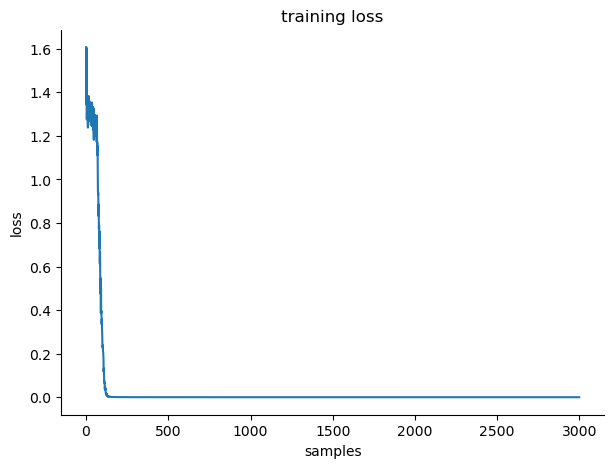

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

ax = axes
item = model1024[1]
ax.plot(item, label="train")

#ax.plot(test_loss, label="test")

ax.set_ylabel("loss")
ax.set_xlabel("samples")
ax.set_title("training loss")
#ax.legend()

sns.despine()

# basic exp

In [33]:
root = "celebA_embeddings/exp_basic"


In [10]:

### seq length 5


series_length = 5
batch_size = 128
seed_value = 100

train_dataloader, test_dataloader = data_prepper_preseparated(series_length, batch_size, seed_value, root,)


model = Vanilla_RNN(input_size=4096, hidden_size=64, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

five = train(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs)

test(model, test_dataloader)

celebA_embeddings/exp_basic/seq5/train/train
celebA_embeddings/exp_basic/seq5/test/test
train:


Counter({4: 480, 3: 352, 2: 232, 1: 120})

test
Counter({4: 480, 3: 352, 2: 232, 1: 120})
Epoch [1/5], Step [1/9], Loss: 1.5802, Accuracy: 60.0/128 (46.88%)
Epoch [2/5], Step [1/9], Loss: 1.4232, Accuracy: 49.0/128 (38.28%)
Epoch [3/5], Step [1/9], Loss: 1.2505, Accuracy: 58.0/128 (45.31%)
Epoch [4/5], Step [1/9], Loss: 1.3503, Accuracy: 51.0/128 (39.84%)
Epoch [5/5], Step [1/9], Loss: 1.1828, Accuracy: 67.0/128 (52.34%)
Test Accuracy: 38.888888888888886%


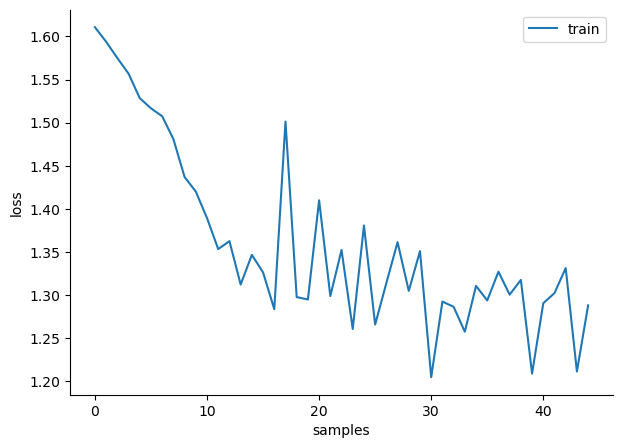

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

ax = axes
item = five[1]
ax.plot(item, label="train")

#ax.plot(test_loss, label="test")

ax.set_ylabel("loss")
ax.set_xlabel("samples")
#ax.set_title("training loss")
ax.legend()

sns.despine()

# prior work

In [ ]:
### seq length 5

series_length = 5
batch_size = 128
seed_value = 100

train_dataloader, val_dataloader, test_dataloader = data_prepper_preseparated(series_length, batch_size, seed_value, root,)

model = Vanilla_RNN(input_size=4096, hidden_size=1024, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

five = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs)

test(model, test_dataloader)

celebA_embeddings/exp_age/seq5/train
celebA_embeddings/exp_age/seq5/val
celebA_embeddings/exp_age/seq5/test
train:
Counter({4: 15589, 3: 8131, 2: 4332, 1: 1789})

val
Counter({4: 5248, 3: 2746, 2: 1453, 1: 620})

test
Counter({4: 5209, 3: 2768, 2: 1480, 1: 627})
Epoch [1/5], Step [1/233], Loss: 1.6059, Accuracy: 13.0/128 (10.16%)
Epoch [1/5], Step [11/233], Loss: 0.2765, Accuracy: 120.0/128 (93.75%)
Epoch [1/5], Step [21/233], Loss: 0.0006, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [31/233], Loss: 0.0001, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [41/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [51/233], Loss: 0.0001, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [61/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [71/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [81/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [91/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [10

In [5]:
### seq length 6

series_length = 6
batch_size = 128
seed_value = 100

train_dataloader, val_dataloader, test_dataloader = data_prepper_preseparated(series_length, batch_size, seed_value, root,)

model = Vanilla_RNN(input_size=4096, hidden_size=1024, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

six = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs)

test(model, test_dataloader)

celebA_embeddings/exp_age/seq6/train
celebA_embeddings/exp_age/seq6/val
celebA_embeddings/exp_age/seq6/test
train:
Counter({5: 13745, 4: 7709, 3: 4608, 2: 2676, 1: 1167})

val
Counter({5: 4592, 4: 2592, 3: 1602, 2: 923, 1: 394})

test
Counter({5: 4547, 4: 2605, 3: 1556, 2: 876, 1: 401})
Epoch [1/5], Step [1/233], Loss: 1.7857, Accuracy: 27.0/128 (21.09%)
Epoch [1/5], Step [11/233], Loss: 0.7652, Accuracy: 111.0/128 (86.72%)
Epoch [1/5], Step [21/233], Loss: 0.0281, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [31/233], Loss: 0.0004, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [41/233], Loss: 0.0001, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [51/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [61/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [71/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [81/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [91/233], Loss: 0.0000, Accuracy: 128.0/128 (100.0

In [6]:
### seq length 7

series_length = 7
batch_size = 128
seed_value = 100

train_dataloader, val_dataloader, test_dataloader = data_prepper_preseparated(series_length, batch_size, seed_value, root,)

model = Vanilla_RNN(input_size=4096, hidden_size=1024, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

seven = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs)

test(model, test_dataloader)

celebA_embeddings/exp_age/seq7/train
celebA_embeddings/exp_age/seq7/val
celebA_embeddings/exp_age/seq7/test
train:
Counter({6: 12213, 5: 7256, 4: 4809, 3: 3055, 2: 1781, 1: 780})

val
Counter({6: 4156, 5: 2418, 4: 1666, 3: 1017, 2: 583, 1: 316})

test
Counter({6: 4053, 5: 2407, 4: 1587, 3: 1028, 2: 592, 1: 275})
Epoch [1/5], Step [1/233], Loss: 1.9432, Accuracy: 8.0/128 (6.25%)
Epoch [1/5], Step [11/233], Loss: 1.0186, Accuracy: 101.0/128 (78.91%)
Epoch [1/5], Step [21/233], Loss: 0.1322, Accuracy: 125.0/128 (97.66%)
Epoch [1/5], Step [31/233], Loss: 0.0054, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [41/233], Loss: 0.0003, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [51/233], Loss: 0.0001, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [61/233], Loss: 0.0001, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [71/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [81/233], Loss: 0.0000, Accuracy: 128.0/128 (100.00%)
Epoch [1/5], Step [91/233], Loss: 0.0000, Acc

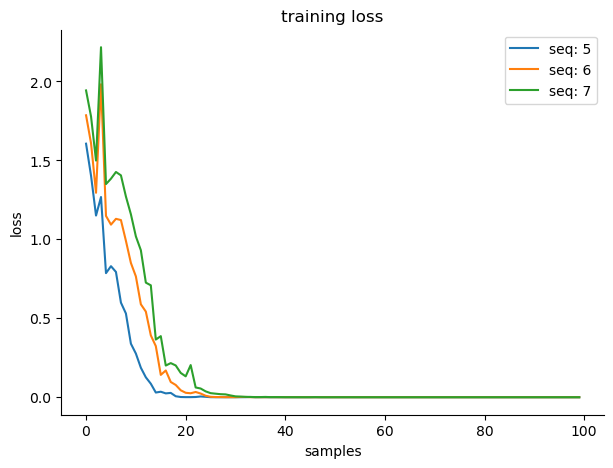

In [27]:
names = [5, 6, 7]

fig, axes = plt.subplots(1, 1, figsize=(7, 5))

ax = axes
for i, item in enumerate([five, six, seven]):
    name = names[i]
    ax.plot(item[1][:100], label=f"seq: {name}")

ax.set_ylabel("loss")
ax.set_xlabel("samples")
ax.set_title("training loss")
ax.legend()



sns.despine()

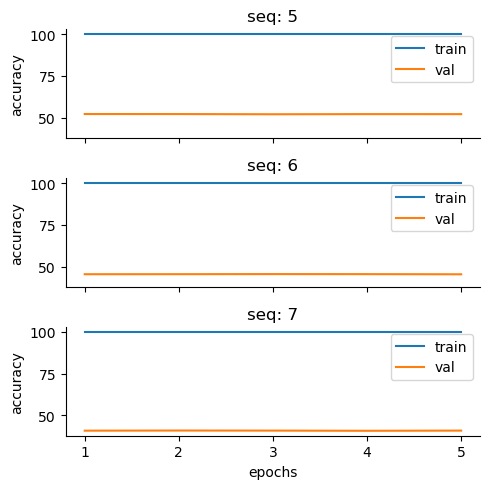

In [19]:
names = [5, 6, 7]


fig, axes = plt.subplots(len(names), 1, figsize=(5,5), sharex=True, sharey=True)


for i, item in enumerate([five, six, seven]):
    ax = axes[i]

    name = names[i]
    ax.plot(item[2], label=f"train")
    ax.plot(item[3], label=f"val")



    ax.set_ylabel("accuracy")
    if i == len(names)-1:
        ax.set_xlabel("epochs")
        ax.set_xticks(range(0,5))
        ax.set_xticklabels(range(1, 6))
    ax.set_title(f"seq: {name}")
    ax.legend()

plt.tight_layout()

sns.despine()

In [13]:
six[2]

[100.0, 100.0, 100.0, 100.0, 100.0]